# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Heng-Jui Chang

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Videos (Mandarin): https://cool.ntu.edu.tw/courses/4793/modules/items/172854  
https://cool.ntu.edu.tw/courses/4793/modules/items/172853  
Video (English): https://cool.ntu.edu.tw/courses/4793/modules/items/176529


Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

If any questions, please contact the TAs via TA hours, NTU COOL, or email.


# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [83]:
data = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

#!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
#!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# load data by using pandas

In [67]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
data = pd.read_csv(data)
data.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [24]:
tt_path = pd.read_csv(tt_path)
tt_path.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,52.071090,8.624001,29.374792,5.391413,2.754804,19.695098,13.685645,24.747837,66.194950,44.873473
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.742461,21.720187,41.375784,9.450179,3.150088,22.075715,17.302077,23.559622,57.015009,38.372829
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.109045,20.123959,40.072556,8.781522,2.888209,23.920870,18.342506,24.993341,55.291498,38.907257
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.442267,16.083529,36.977612,5.199286,2.575347,21.073800,12.087171,18.608723,67.036197,43.142779
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.588783,19.503010,42.631236,11.549771,8.530551,15.896575,11.781634,15.065228,61.196518,43.574676


# select data

In [5]:
'''
choose_column= data['wearing_mask.1','travel_outside_state.1']
tr_path =choose_column
tr_path
'''

"\nchoose_column= data['wearing_mask.1','travel_outside_state.1']\ntr_path =choose_column\ntr_path\n"

# **Import Some Packages**

In [84]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Some Utilities**

You do not need to modify this part.

In [85]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Preprocess**

We have three kinds of datasets:
* `train`: for training
* `dev`: for validation
* `test`: for testing (w/o target value)

## **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

Finishing `TODO` below might make you pass medium baseline.

In [86]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [87]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [57]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# 128 Neural

In [52]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# 256 Neural

In [88]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# **Train/Dev/Test**

## **Training**

In [89]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

## **Validation**

In [90]:
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

## **Testing**

In [91]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [61]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# change optim Adam

In [16]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001                 # learning rate of SGD
                     # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# change Betch_size 1

In [76]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 1,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001                 # learning rate of SGD
                     # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# change Betch_size 16

In [92]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = False                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 16,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001                 # learning rate of SGD
                     # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

# **Load data and model**

In [93]:
#data = data.astype(str)
tr_set = prep_dataloader(data, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(data, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [94]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

# **Start Training!**

In [64]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 78.8524)
Saving model (epoch =    2, loss = 37.6170)
Saving model (epoch =    3, loss = 26.1203)
Saving model (epoch =    4, loss = 16.1862)
Saving model (epoch =    5, loss = 9.7153)
Saving model (epoch =    6, loss = 6.3701)
Saving model (epoch =    7, loss = 5.1802)
Saving model (epoch =    8, loss = 4.4255)
Saving model (epoch =    9, loss = 3.8009)
Saving model (epoch =   10, loss = 3.3691)
Saving model (epoch =   11, loss = 3.0943)
Saving model (epoch =   12, loss = 2.8176)
Saving model (epoch =   13, loss = 2.6274)
Saving model (epoch =   14, loss = 2.4542)
Saving model (epoch =   15, loss = 2.3012)
Saving model (epoch =   16, loss = 2.1766)
Saving model (epoch =   17, loss = 2.0641)
Saving model (epoch =   18, loss = 1.9399)
Saving model (epoch =   19, loss = 1.8978)
Saving model (epoch =   20, loss = 1.7950)
Saving model (epoch =   21, loss = 1.7164)
Saving model (epoch =   22, loss = 1.6455)
Saving model (epoch =   23, loss = 1.5912)
Saving 

# 128

In [59]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 38.2027)
Saving model (epoch =    3, loss = 20.5664)
Saving model (epoch =    4, loss = 9.0663)
Saving model (epoch =    5, loss = 7.5639)
Saving model (epoch =    6, loss = 6.2694)
Saving model (epoch =    7, loss = 4.9485)
Saving model (epoch =    8, loss = 3.8689)
Saving model (epoch =    9, loss = 3.4882)
Saving model (epoch =   10, loss = 3.2672)
Saving model (epoch =   11, loss = 2.8618)
Saving model (epoch =   12, loss = 2.7460)
Saving model (epoch =   13, loss = 2.4874)
Saving model (epoch =   14, loss = 2.3687)
Saving model (epoch =   15, loss = 2.2131)
Saving model (epoch =   16, loss = 2.1563)
Saving model (epoch =   17, loss = 2.0396)
Saving model (epoch =   18, loss = 1.9815)
Saving model (epoch =   19, loss = 1.8692)
Saving model (epoch =   20, loss = 1.8018)
Saving model (epoch =   21, loss = 1.7445)
Saving model (epoch =   22, loss = 1.6790)
Saving model (epoch =   23, loss = 1.6319)
Saving model (epoch =   24, loss = 1.5861)
Saving mo

# 256

In [208]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 38.5879)
Saving model (epoch =    2, loss = 35.4151)
Saving model (epoch =    3, loss = 11.4263)
Saving model (epoch =    5, loss = 7.5308)
Saving model (epoch =    6, loss = 5.2419)
Saving model (epoch =    7, loss = 4.3194)
Saving model (epoch =    8, loss = 3.8057)
Saving model (epoch =    9, loss = 3.3251)
Saving model (epoch =   10, loss = 3.0578)
Saving model (epoch =   11, loss = 2.7954)
Saving model (epoch =   12, loss = 2.5703)
Saving model (epoch =   13, loss = 2.4203)
Saving model (epoch =   14, loss = 2.2635)
Saving model (epoch =   15, loss = 2.1377)
Saving model (epoch =   16, loss = 2.0493)
Saving model (epoch =   17, loss = 1.9679)
Saving model (epoch =   18, loss = 1.8606)
Saving model (epoch =   19, loss = 1.7880)
Saving model (epoch =   20, loss = 1.7318)
Saving model (epoch =   21, loss = 1.6603)
Saving model (epoch =   22, loss = 1.6219)
Saving model (epoch =   23, loss = 1.5780)
Saving model (epoch =   24, loss = 1.5210)
Saving m

# change optim

In [223]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 282.5740)
Saving model (epoch =    2, loss = 240.3181)
Saving model (epoch =    3, loss = 190.7273)
Saving model (epoch =    4, loss = 137.1409)
Saving model (epoch =    5, loss = 88.0978)
Saving model (epoch =    6, loss = 52.9460)
Saving model (epoch =    7, loss = 36.4482)
Saving model (epoch =    8, loss = 31.7930)
Saving model (epoch =    9, loss = 29.3450)
Saving model (epoch =   10, loss = 26.5065)
Saving model (epoch =   11, loss = 24.4340)
Saving model (epoch =   12, loss = 22.8836)
Saving model (epoch =   13, loss = 21.4833)
Saving model (epoch =   14, loss = 20.1332)
Saving model (epoch =   15, loss = 18.8828)
Saving model (epoch =   16, loss = 17.6727)
Saving model (epoch =   17, loss = 16.5272)
Saving model (epoch =   18, loss = 15.3833)
Saving model (epoch =   19, loss = 14.3221)
Saving model (epoch =   20, loss = 13.2873)
Saving model (epoch =   21, loss = 12.3128)
Saving model (epoch =   22, loss = 11.3656)
Saving model (epoch =   23, 

# change betch_size 1

In [79]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 2.5204)
Saving model (epoch =    2, loss = 2.2410)
Saving model (epoch =    3, loss = 1.7981)
Saving model (epoch =    4, loss = 1.5653)
Saving model (epoch =    5, loss = 1.3191)
Saving model (epoch =    6, loss = 1.2073)
Saving model (epoch =   13, loss = 1.0135)
Saving model (epoch =   24, loss = 0.8427)
Saving model (epoch =   54, loss = 0.8092)
Saving model (epoch =   58, loss = 0.8026)
Saving model (epoch =   80, loss = 0.7862)
Finished training after 281 epochs


# change betch_size16

In [95]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 20.8271)
Saving model (epoch =    2, loss = 9.5643)
Saving model (epoch =    3, loss = 4.7050)
Saving model (epoch =    4, loss = 2.7174)
Saving model (epoch =    5, loss = 2.0158)
Saving model (epoch =    6, loss = 1.7547)
Saving model (epoch =    7, loss = 1.5756)
Saving model (epoch =    8, loss = 1.4983)
Saving model (epoch =    9, loss = 1.3401)
Saving model (epoch =   11, loss = 1.1384)
Saving model (epoch =   13, loss = 1.1008)
Saving model (epoch =   16, loss = 1.0643)
Saving model (epoch =   17, loss = 0.9759)
Saving model (epoch =   19, loss = 0.9561)
Saving model (epoch =   20, loss = 0.9459)
Saving model (epoch =   22, loss = 0.9374)
Saving model (epoch =   24, loss = 0.8954)
Saving model (epoch =   26, loss = 0.8806)
Saving model (epoch =   30, loss = 0.8582)
Saving model (epoch =   31, loss = 0.8414)
Saving model (epoch =   32, loss = 0.7953)
Saving model (epoch =   37, loss = 0.7659)
Saving model (epoch =   91, loss = 0.7186)
Saving mod

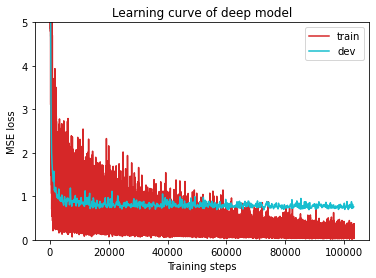

In [96]:
plot_learning_curve(model_loss_record, title='deep model')

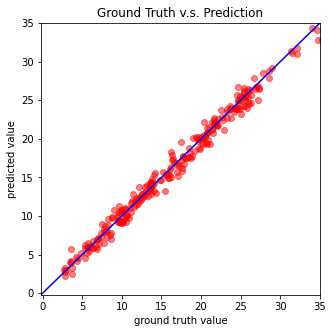

In [97]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

# **Testing**
The predictions of your model on testing set will be stored at `pred.csv`.

In [98]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv


# **Hints**

## **Simple Baseline**
* Run sample code

## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author. 

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
